In [8]:
import pickle
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
with open('scoremat.pkl','rb') as f:
    mat = pickle.load(f)
mat.shape

(6016, 6016)

In [10]:
mat1 = mat*1000
mat1.max()

1000.0

In [11]:
mat1[0]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [12]:
mat.diagonal()

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [13]:
print(mat.max())
print(mat.mean(1))
print(mat.min())
print(mat.sum(1))

1.0
[0.00016622 0.00016622 0.00016622 ... 0.00016622 0.00016622 0.00016622]
0.0
[1. 1. 1. ... 1. 1. 1.]


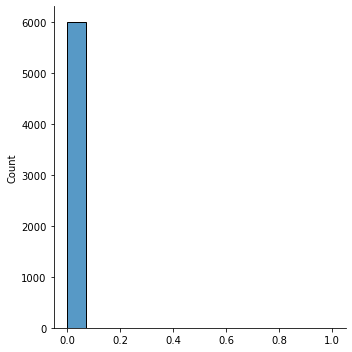

In [14]:
sns.displot(mat[100])

In [42]:
num = torch.tensor([[ 3.1348e+00, -1.4505e-01, -1.4832e+00, -2.8843e+00, -1.2542e+00,  8.3138e-01, -1.0000e+09, -1.0000e+09],
                   [ -1.4505e-01, 3.1348e+00,  -1.4832e+00, -1.2542e+00, -2.8843e+00,   8.3138e-01, -1.0000e+09, -1.0000e+09]])

In [43]:
num.shape

torch.Size([2, 8])

In [44]:
sm = nn.Softmax(dim=-1)(num)
sm

tensor([[0.8604, 0.0324, 0.0085, 0.0021, 0.0107, 0.0860, 0.0000, 0.0000],
        [0.0324, 0.8604, 0.0085, 0.0107, 0.0021, 0.0860, 0.0000, 0.0000]])

In [45]:
_,index = torch.topk(sm,5,dim=-1)
index

tensor([[0, 5, 1, 4, 2],
        [1, 5, 0, 3, 2]])

In [46]:
x = torch.zeros(2,8)
x

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

In [69]:
z = []
for j in range(2):
    y = x[j]
    #print(y)
    for k in range(5):
        y[index[j][k]]=1
    z.append(y)
    q = torch.stack(z,dim=0)
q

tensor([[1., 1., 1., 0., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0., 1., 0., 0.]])

### Load Dataset

In [2]:
# f = open("./data/preprocessed/tcga_brca_dataset.pkl",'rb')
# data_list = pickle.load(f)
# f.close()

#f = open("./data/preprocessed/cv/tcga_brca_dataset_train_0.pkl",'rb')
#train_list = pickle.load(f)
#f.close()

#f = open("./data/preprocessed/cv/tcga_brca_dataset_test_0.pkl",'rb')
#test_list = pickle.load(f)
#f.close()

f = open("./data/preprocessed/cv/netics_exp_sample_train_0.pkl",'rb')
train_list = pickle.load(f)
f.close()

f = open("./data/preprocessed/cv/netics_exp_sample_test_0.pkl",'rb')
test_list = pickle.load(f)
f.close()

In [2]:
# f = open("./data/preprocessed/tcga_brca_dataset.pkl",'rb')
# data_list = pickle.load(f)
# f.close()
#netics
f = open("./data/preprocessed/cv/netics_exp_sample_train_0.pkl",'rb')
trainlist_sample = pickle.load(f)
f.close()

f = open("./data/preprocessed/cv/netics_exp_sample_test_0.pkl",'rb')
testlist_sample = pickle.load(f)
f.close()

f = open("./data/preprocessed/cv/netics_exp_TF_train_0.pkl",'rb')
trainlist_TF = pickle.load(f)
f.close()

f = open("./data/preprocessed/cv/netics_exp_TF_test_0.pkl",'rb')
testlist_TF = pickle.load(f)
f.close()
#len(test_list)

### Get Dataloader

In [3]:
train_loader = DataLoader(train_list,batch_size=1)
test_loader = DataLoader(test_list, batch_size=1)

In [3]:
#netics
trainloader_sample = DataLoader(trainlist_sample,batch_size=1)
testloader_sample = DataLoader(testlist_sample, batch_size=1)
trainloader_TF = DataLoader(trainlist_TF, batch_size=1)
testloader_TF = DataLoader(testlist_TF, batch_size=1)

### Model Configuration

In [4]:
#num_genes =9630
#netics
num_genes = 6016
num_class = 5
num_layers = 4

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.simpleGCN_SAGPOOL(num_genes,num_class,num_layers=num_layers).to(device)
#model = model.pagerank_SAGPOOL(num_genes,num_class).to(device)
loss_op = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

save_path = "./data/model/simpleGCN_SAGPOOL"
print("Save path:", save_path)

simpleGCN_SAGPOOL:4 layers
cuda
Save path: ./data/model/simpleGCN_SAGPOOL


### Train and Test

In [5]:
def train():
    model.train()
    
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_op(output, data.y)
        total_loss+=loss.item()*data.num_graphs
        loss.backward()
        optimizer.step()
                    
    return total_loss / len(train_loader.dataset)

def test(loader):
    model.eval()

    ys, preds = [], []
    for data in loader:
        ys.append(data.y)
        out = model(data.to(device))
        pred = out.max(dim=1)[1]
        preds.append(pred.cpu())
    
    y, pred = torch.cat(ys, dim=0).numpy(), torch.cat(preds, dim=0).numpy()
    return f1_score(y, pred, average='weighted') if pred.sum() > 0 else 0

In [5]:
#netics

def train():
    model.train()
    
    total_loss = 0
    for data1, data2 in zip(trainloader_sample, trainloader_TF):
        data1 = data1.to(device)
        data2 = data2.to(device)
        
        optimizer.zero_grad()
        output = model(data1, data2)
        loss = loss_op(output, data1.y)
        total_loss+=loss.item()*data1.num_graphs
        loss.backward()
        optimizer.step()
                    
    return total_loss / len(trainloader_sample.dataset)

def test(loader1, loader2):
    model.eval()

    ys, preds = [], []
    for data1, data2 in zip(loader1, loader2):
        ys.append(data1.y)
        out = model(data1.to(device),data2.to(device))
        pred = out.max(dim=1)[1]
        preds.append(pred.cpu())
    
    y, pred = torch.cat(ys, dim=0).numpy(), torch.cat(preds, dim=0).numpy()
    return f1_score(y, pred, average='weighted') #if pred.sum() > 0 else 0

In [6]:
if not os.path.exists(save_path):
    os.makedirs(save_path)
        
for epoch in range(1, 1001):
    loss = train()
    
    if epoch%100 == 0:
        torch.save(model.state_dict(),save_path+"/model_epoch{}".format(epoch))

    test_f1 = test(test_loader)
    print('Epoch: {:02d}, Loss: {:.4f}, Test: {:.4f}'.format(epoch, loss, test_f1))

/home/minjae/miniconda3/envs/minjae/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch: 01, Loss: 1.3938, Test: 0.1608
Epoch: 02, Loss: 1.3769, Test: 0.1608
Epoch: 03, Loss: 1.3743, Test: 0.1608
Epoch: 04, Loss: 1.3726, Test: 0.1608
Epoch: 05, Loss: 1.3716, Test: 0.1608
Epoch: 06, Loss: 1.3703, Test: 0.1608
Epoch: 07, Loss: 1.3684, Test: 0.1608
Epoch: 08, Loss: 1.3649, Test: 0.1608
Epoch: 09, Loss: 1.3617, Test: 0.1608
Epoch: 10, Loss: 1.3550, Test: 0.1608
Epoch: 11, Loss: 1.3471, Test: 0.1608
Epoch: 12, Loss: 1.3393, Test: 0.1608
Epoch: 13, Loss: 1.3296, Test: 0.1608
Epoch: 14, Loss: 1.3188, Test: 0.1608
Epoch: 15, Loss: 1.3037, Test: 0.1608
Epoch: 16, Loss: 1.2913, Test: 0.1608
Epoch: 17, Loss: 1.2749, Test: 0.1608
Epoch: 18, Loss: 1.2579, Test: 0.1569
Epoch: 19, Loss: 1.2411, Test: 0.1620
Epoch: 20, Loss: 1.2217, Test: 0.1582
Epoch: 21, Loss: 1.2040, Test: 0.1594
Epoch: 22, Loss: 1.1912, Test: 0.1594
Epoch: 23, Loss: 1.1743, Test: 0.1607
Epoch: 24, Loss: 1.1561, Test: 0.1633
Epoch: 25, Loss: 1.1428, Test: 0.1593
Epoch: 26, Loss: 1.1275, Test: 0.1540
Epoch: 27, L

OSError: [Errno 28] No space left on device

In [ ]:
#netics
if not os.path.exists(save_path):
    os.makedirs(save_path)
        
for epoch in range(1, 1001):
    loss = train()
    
    if epoch%100 == 0:
        torch.save(model.state_dict(),save_path+"/model_epoch{}".format(epoch))

    test_f1 = test(testloader_sample, testloader_TF)
    print('Epoch: {:02d}, Loss: {:.4f}, Test: {:.4f}'.format(epoch, loss, test_f1))

### Reference 
@torch.no_grad()
#https://github.com/rusty1s/pytorch_geometric/blob/master/examples/ppi.py
#https://github.com/rusty1s/pytorch_geometric/blob/master/examples/proteins_topk_pool.py
